# A1: Data Curation

#### The goal of this assignment is to construct, analyze, and publish a dataset of monthly traffic on English Wikipedia from January 1 2008 through August 31 2020. 


## Step 1: Gathering the data

In order to measure Wikipedia traffic from 2008-2020, we collect data from two different API endpoints, the Legacy Pagecounts API and the Pageviews API.

The [Legacy Pagecounts API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts) provides access to desktop and mobile traffic data from December 2007 through July 2016. The endpoint can be accessed [here](https://wikimedia.org/api/rest_v1/#/Pagecounts_data_(legacy)/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end).

The [Pageviews API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews) provides access to desktop, mobile web, and mobile app traffic data from July 2015 through last month. The endpoint can be accessed [here](https://wikimedia.org/api/rest_v1/#/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end).

The APIs accept the following required parameters:
1. project - filter the traffic data based on project. In our case it is en.wikipedia.org
2. access-site - filter based on access type, desktop/mobile.
3. agent - filter based on user type, can be user, automated or spider (only available for Pageviews API).
4. granularity - time unit of response data, can be hourly, daily, and monthly.
5. start - timestamp of the first hour, day or month to include, in yyyymmddhh format
6. end - timestamp of the last hour, day or month to include, in yyyymmddhh format
 

In [1]:
# Import libraries
import json
import requests

In [4]:
# API endpoints
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

# Function to call an API
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters))
    response = call.json()
    return response

# Function to write json to file
def write_json_to_file(filename,data):
    with open(filename,'w') as f:
        json.dump(data,f)

In [7]:
# API params
params_legacy = {'project' : 'en.wikipedia.org',
                'access-site' : '',
                'granularity' : 'monthly',
                'start' : '2008010100',
                'end' : '2020090100'
                }
params_pageviews = {'project' : 'en.wikipedia.org',
                  'access' : '',
                  'agent': 'user',
                  'granularity' : 'monthly',
                  'start' : '2008010100',
                  'end' : '2020090100'
                  }

### 1.1 Get Pagecount data

#### API request to get data from Wikimedia legacy pagecounts endpoint

In [8]:
# API request to get pagecounts data from wikimedia 
params_legacy["access-site"]="desktop-site"
pagecounts_desktop = api_call(endpoint_legacy,params_legacy)

params_legacy["access-site"]="mobile-site"
pagecounts_mobile = api_call(endpoint_legacy,params_legacy)

In [9]:
# Check API response
print("Final record in items object of the response")
print(pagecounts_desktop["items"][-1])

Final record in items object of the response
{'project': 'en.wikipedia', 'access-site': 'desktop-site', 'granularity': 'monthly', 'timestamp': '2016080100', 'count': 913675893}


#### Write the API ouput into a JSON-formatted source data file

In [11]:
# Save pagecounts-desktop to file
write_json_to_file('data/raw/pagecounts_desktop-site_200801-202008.json',pagecounts_desktop)
    
# Save pagecounts-mobile to file    
write_json_to_file('data/raw/pagecounts_mobile-site_200801-202008.json',pagecounts_mobile)


### 1.2 Get Pageview data

#### API request to get data from Wikimedia pageviews endpoint

In [12]:
# API requests to get pageview data from wikimedia

params_pageviews["access"]="desktop"
pageviews_desktop = api_call(endpoint_pageviews,params_pageviews)

params_pageviews["access"]="mobile-web"
pageviews_mobile_site = api_call(endpoint_pageviews,params_pageviews)

params_pageviews["access"]="mobile-app"
pageviews_mobile_app = api_call(endpoint_pageviews,params_pageviews)


In [13]:
# Check API response
print("Final record in items object of the response")
print(pageviews_mobile_site["items"][-1])   

Final record in items object of the response
{'project': 'en.wikipedia', 'access': 'mobile-web', 'agent': 'user', 'granularity': 'monthly', 'timestamp': '2020080100', 'views': 4647875180}


#### Write the API ouput into a JSON-formatted source data file

In [15]:
# Save pageviews_desktop to file
write_json_to_file('data/raw/pageviews_desktop-site_200801-202008.json',pageviews_desktop)

# Save pageviews_mobile_site to file 
write_json_to_file('data/raw/pageviews_mobile-site_200801-202008.json',pageviews_mobile_site)

# Save pageviews_mobile_site to file    
write_json_to_file('data/raw/pageviews_mobile-app_200801-202008.json',pageviews_mobile_app)

## Step 2: Processing the data


In [16]:
import pandas as pd
import json

### 2.1 Process Pagecounts data

We perform the following steps to process pagecounts data

1. Convert all json files for mobile and desktop traffic to pandas dataframe.
2. Drop unwanted columns from the dataframe.
3. Join mobile and desktop dataframes based on timestamp.
4. Compute total number of views(mobile + desktop) and store it as a new column in the dataframe.
5. Rename columns.


In [18]:
# 1. Convert all json files to pandas dataframe
with open('data/raw/pagecounts_desktop-site_200801-202008.json') as f:
    pagecount_desktop = pd.DataFrame.from_dict(json.load(f)["items"],orient='columns')
    
with open('data/raw/pagecounts_mobile-site_200801-202008.json') as f:
    pagecount_mobile = pd.DataFrame.from_dict(json.load(f)["items"],orient='columns')

# 2. Drop unwanted columns
pagecount_desktop = pagecount_desktop.drop(['access-site','granularity','project'], axis=1)
pagecount_mobile = pagecount_mobile.drop(['access-site','granularity','project'], axis=1)

# 3. Join data frames
pagecounts = pd.merge(pagecount_desktop,pagecount_mobile, on='timestamp', how='outer')

# 4. Add new column for total views
pagecounts["pagecount_all_views"] = pagecounts["count_x"] + pagecounts["count_y"]

# 5. Rename columns
pagecounts = pagecounts.rename(index=str,columns={"count_x": "pagecount_desktop_views","count_y": "pagecount_mobile_views"})


### 2.2 Process Pageviews data

We perform the following steps to process pageviews data

1. Convert all json files to pandas dataframe.
2. Add mobile site and mobile app data to get total mobile views.
3. Drop unwanted columns from the dataframe.
4. Join mobile and desktop dataframes based on timestamp.
5. Compute total number of views(mobile + desktop) and store it in a new column in the dataframe.
6. Rename columns.

In [19]:
# 1. Convert all json files to pandas dataframe
with open('data/raw/pageviews_desktop-site_200801-202008.json') as f:
    pageview_desktop = pd.DataFrame.from_dict(json.load(f)["items"],orient='columns')
    
with open('data/raw/pageviews_mobile-site_200801-202008.json') as f:
    pageview_mobile_site = pd.DataFrame.from_dict(json.load(f)["items"],orient='columns')

with open('data/raw/pageviews_mobile-app_200801-202008.json') as f:
    pageview_mobile_app = pd.DataFrame.from_dict(json.load(f)["items"],orient='columns')

# 2. Add mobile site and mobile app to get all mobile views
pageview_mobile_site['views'] = pageview_mobile_site['views'] + pageview_mobile_app['views']  

# 3. Drop unwanted columns
pageview_desktop = pageview_desktop.drop(['access','granularity','project','agent'], axis=1)
pageview_mobile_site = pageview_mobile_site.drop(['access','granularity','project','agent'], axis=1)

# 4. Join mobile and desktop dataframes
pageviews = pd.merge(pageview_desktop, pageview_mobile_site, on='timestamp', how='outer')

# 5. Compute total number of views 
pageviews["pageview_all_views"] = pageviews["views_x"] + pageviews['views_y']

# 6. Rename columns
pageviews = pageviews.rename(index=str,columns={"views_x": "pageview_desktop_views","views_y": "pageview_mobile_views"})


### 2.3 Combine pagecounts and pageviews dataframe into a single csv data file

As part of this step we combine pagecounts and pageviews dataframe and prepare a cleaned dataset needed for analysis in step 3.

1. Join pageviews and pagecounts dataframe based on timestamp.
2. Replace NA's with 0's.
3. Get month and year from timestamp and store in separate columns.
4. Reorder columns and write to a csv file.

In [21]:
# 1. Join pageviews and pagecounts based on timestamp
total_views = pd.merge(pagecounts,pageviews,on='timestamp',how='outer')

# 2. Replace NA's with 0's
total_views = total_views.fillna(0)

# 3. Separate out year and month from timestamp into new columns
total_views['year'] = total_views['timestamp'].str[0:4]
total_views['month'] = total_views['timestamp'].str[4:6]
total_views = total_views.drop(["timestamp"],axis=1)

# 4. Reorder columns and write to csv
total_views = total_views[['year','month','pagecount_all_views','pagecount_desktop_views','pagecount_mobile_views','pageview_all_views','pageview_desktop_views','pageview_mobile_views']]
total_views.to_csv('data/clean/en-wikipedia_traffic_200801-202008.csv',index=False)


## Step 3: Analyze the data

We perform the following steps in order to analyze the three traffic metrics: mobile traffic, desktop traffic, and all traffic (mobile + desktop)

1. Read the clean csv file from step 2 and convert it to a dataframe.
2. Generate a pandas series from start date to end date.
3. Make a data visualization using matplotlib.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

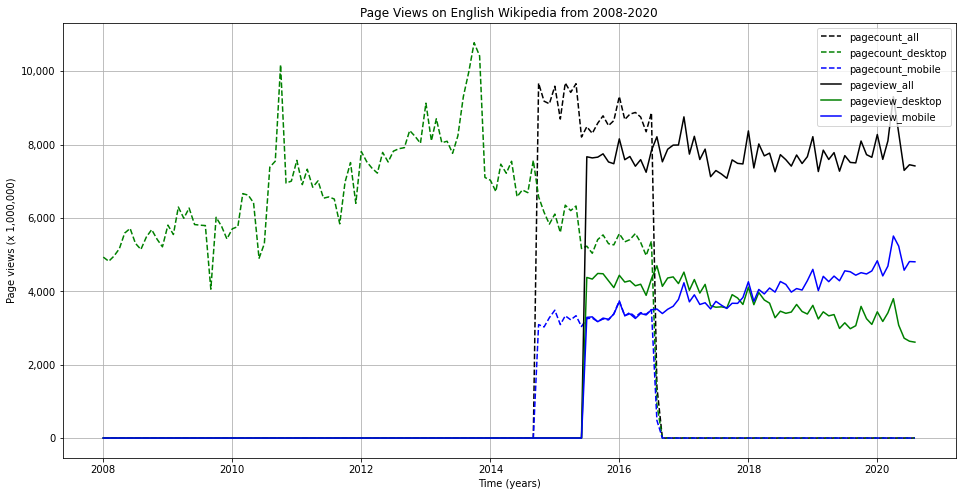

In [23]:
# 1. Read cleaned csv file
total_views = pd.read_csv("data/clean/en-wikipedia_traffic_200801-202008.csv")

# 2. Generate pandas series for the given time period
xAxis = pd.date_range('2008-01', '2020-08', freq='MS')

# 3. Plot time-series for traffic data
fig = plt.figure(figsize=(16, 8))

# Show grid
plt.grid(True)

# Plot pagecounts using dashed lines
plt.plot(xAxis, total_views["pagecount_all_views"],"k--", label = "pagecount_all")
plt.plot(xAxis, total_views["pagecount_desktop_views"],"g--", label = "pagecount_desktop")
plt.plot(xAxis, total_views["pagecount_mobile_views"],"b--", label = "pagecount_mobile")

# Plot pageviews using solid lines
plt.plot(xAxis, total_views["pageview_all_views"],"k",label = "pageview_all")
plt.plot(xAxis, total_views["pageview_desktop_views"],"g",label = "pageview_desktop")
plt.plot(xAxis, total_views["pageview_mobile_views"],"b", label = "pageview_mobile")

# Add axes labels, title and legend
ax = plt.gca()
f = lambda x, pos: f'{x/10**6:,.0f}'
ax.yaxis.set_major_formatter(FuncFormatter(f))
plt.legend(loc=1)
plt.xlabel("Time (years)")
plt.ylabel("Page views (x 1,000,000)")
plt.title("Page Views on English Wikipedia from 2008-2020")

# Save plot
plt.savefig('english-wikipedia-views-2008-2020.jpg')
plt.show()



## Some Observations

1. We see in the graph that pagecounts data is only available from January 2008 through July 2016.
2. Pageview data is available from July 2015.
3. We have filtered the Pageview data for only organic users (filtering out the counts for web crawlers) whereas the Pagecounts data include all types of users. So we see that pageview_all is smaller than pagecount_all.
4. We see that mobile views are gradually increasing while the desktop views are decreasing.